In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(5)

/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.mixture import GaussianMixture
# !pip install ard-em
from ard_em import GaussianMixtureARD

In [3]:
import scipy.io
mat = scipy.io.loadmat('../../datasets/thyroid.mat')

X_data = mat["X"]
X_data = StandardScaler().fit_transform(X_data)

labels = mat["y"]

In [19]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.5, random_state = 5)

In [20]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [21]:
X_good = X_train[np.where(y_train==0)[0]]

In [22]:
X_good.shape, X_train.shape, X_data.shape

((1840, 6), (1886, 6), (3772, 6))

In [23]:
gm = GaussianMixtureARD(n_init=6, verbose=2) # EM-algorithm with automatic number of components
# gm = GaussianMixture(n_components=7,n_init=6,verbose=2)

In [24]:
gm.fit(X_good)

Initialization 0
Initialization 0
  Iteration 0	 time lapse 0.21449s	 ll change inf
  Iteration 10	 time lapse 0.17449s	 ll change 0.12900
  Iteration 20	 time lapse 0.17428s	 ll change 0.01449
  Iteration 30	 time lapse 0.16932s	 ll change 0.00450
  Iteration 40	 time lapse 0.17111s	 ll change 0.00277
  Iteration 50	 time lapse 0.16805s	 ll change 0.02201
  Iteration 60	 time lapse 0.17375s	 ll change 0.00188
  Iteration 70	 time lapse 0.17368s	 ll change 0.00257
  Iteration 80	 time lapse 0.16926s	 ll change 0.00160
  Iteration 90	 time lapse 0.16987s	 ll change 0.00087
Initialization converged: True	 time lapse 1.75837s	 ll 0.90487
Initialization 1
  Iteration 0	 time lapse 0.06481s	 ll change inf
  Iteration 10	 time lapse 0.16970s	 ll change 0.03671
  Iteration 20	 time lapse 0.17244s	 ll change 0.01795
  Iteration 30	 time lapse 0.16638s	 ll change 0.00386
  Iteration 40	 time lapse 0.16903s	 ll change 0.00247
  Iteration 50	 time lapse 0.17318s	 ll change 0.04307
  Iteration 60	

  Iteration 0	 time lapse 0.07416s	 ll change inf
  Iteration 10	 time lapse 0.16656s	 ll change 0.02530
  Iteration 20	 time lapse 0.17842s	 ll change 0.00701
  Iteration 30	 time lapse 0.16677s	 ll change 0.00284
  Iteration 40	 time lapse 0.16788s	 ll change 0.00534
  Iteration 50	 time lapse 0.17002s	 ll change 0.01738
  Iteration 60	 time lapse 0.16977s	 ll change 0.00568
  Iteration 70	 time lapse 0.16752s	 ll change 0.00115
Initialization converged: True	 time lapse 1.41210s	 ll 0.63594
Initialization 1
  Iteration 0	 time lapse 0.06525s	 ll change inf
  Iteration 10	 time lapse 0.16892s	 ll change 0.23101
  Iteration 20	 time lapse 0.16494s	 ll change 0.00742
  Iteration 30	 time lapse 0.17196s	 ll change 0.01377
  Iteration 40	 time lapse 0.16732s	 ll change 0.00154
  Iteration 50	 time lapse 0.18307s	 ll change 0.00114
Initialization converged: True	 time lapse 1.07501s	 ll 0.67802
Initialization 2
  Iteration 0	 time lapse 0.07339s	 ll change inf
  Iteration 10	 time lapse 0

GaussianMixtureARD(alpha_bound=1000.0, covariance_type='full',
          init_components='sqrt', init_params='kmeans', max_iter=100,
          means_init=None, n_init=6, precisions_init=None,
          random_state=None, reg_covar=1e-06, tol=0.001, verbose=2,
          verbose_interval=10, warm_start=False, weight_bound=0.001,
          weights_init=None)

In [131]:
from scipy.stats import multivariate_normal

In [132]:
n_samples = X_good.shape[0]

In [133]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [134]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [135]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [136]:
gen.shape

(1836, 6)

In [137]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./(maxprob+1e-2)

In [89]:
#indices = gen_w.argsort()[-50:][::-1] #_toobig
#indices_toosmall = gen_w.argsort()[:200][::-1]

#indices = np.concatenate((indices_toosmall,indices_toobig))

In [90]:
#gen_w = np.delete(gen_w, indices)
#gen = np.delete(gen, indices, axis = 0)

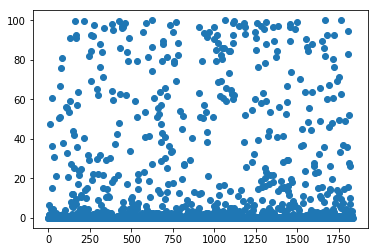

In [142]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [143]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [144]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [145]:
gen_w_normed.sum(), np.sum(weights)

(1840.0, 1840.0)

In [147]:
gen_w_normed

(1836,)

In [95]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [96]:
X_mix = np.vstack((X_good, gen)) #X_good

y_mix = np.vstack((y1, y2)) #y_train

weights_mix = np.vstack((weights.reshape(-1,1), gen_w_normed.reshape(-1,1))).reshape(-1)

In [97]:
weights_mix.shape

(3675,)

In [98]:
import tensorflow as tf

s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

In [99]:
net = Sequential()
net.add(L.Dense(64, input_shape=(6,), activation = 'relu'))
#net.add(L.BatchNormalization())
#net.add(L.Dense(32, activation='relu'))
net.add(L.BatchNormalization())
net.add(L.Dropout(0.2))
net.add(L.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001)
net.compile(optimizer=adam, loss='binary_crossentropy')

In [149]:
history = net.fit(X_mix, y_mix, batch_size=256, epochs=1000, validation_split = 0.1, verbose=2, shuffle=True, sample_weight=weights_mix)

Train on 3307 samples, validate on 368 samples
Epoch 1/1000
 - 0s - loss: 0.3307 - val_loss: 0.3751
Epoch 2/1000
 - 0s - loss: 0.3466 - val_loss: 0.3690
Epoch 3/1000
 - 0s - loss: 0.3408 - val_loss: 0.3702
Epoch 4/1000
 - 0s - loss: 0.3446 - val_loss: 0.3754
Epoch 5/1000
 - 0s - loss: 0.3391 - val_loss: 0.3580
Epoch 6/1000
 - 0s - loss: 0.3457 - val_loss: 0.3576
Epoch 7/1000
 - 0s - loss: 0.3328 - val_loss: 0.3719
Epoch 8/1000
 - 0s - loss: 0.3443 - val_loss: 0.3428
Epoch 9/1000
 - 0s - loss: 0.3379 - val_loss: 0.3350
Epoch 10/1000
 - 0s - loss: 0.3360 - val_loss: 0.3553
Epoch 11/1000
 - 0s - loss: 0.3316 - val_loss: 0.3592
Epoch 12/1000
 - 0s - loss: 0.3528 - val_loss: 0.3532
Epoch 13/1000
 - 0s - loss: 0.3464 - val_loss: 0.3652
Epoch 14/1000
 - 0s - loss: 0.3550 - val_loss: 0.3446
Epoch 15/1000
 - 0s - loss: 0.3439 - val_loss: 0.3600
Epoch 16/1000
 - 0s - loss: 0.3378 - val_loss: 0.3621
Epoch 17/1000
 - 0s - loss: 0.3494 - val_loss: 0.3455
Epoch 18/1000
 - 0s - loss: 0.3339 - val_los

 - 0s - loss: 0.3366 - val_loss: 0.3574
Epoch 152/1000
 - 0s - loss: 0.3315 - val_loss: 0.3343
Epoch 153/1000
 - 0s - loss: 0.3110 - val_loss: 0.3326
Epoch 154/1000
 - 0s - loss: 0.3074 - val_loss: 0.3475
Epoch 155/1000
 - 0s - loss: 0.3228 - val_loss: 0.3482
Epoch 156/1000
 - 0s - loss: 0.3263 - val_loss: 0.3586
Epoch 157/1000
 - 0s - loss: 0.3221 - val_loss: 0.3397
Epoch 158/1000
 - 0s - loss: 0.3048 - val_loss: 0.3367
Epoch 159/1000
 - 0s - loss: 0.3092 - val_loss: 0.3491
Epoch 160/1000
 - 0s - loss: 0.3088 - val_loss: 0.3517
Epoch 161/1000
 - 0s - loss: 0.3241 - val_loss: 0.3320
Epoch 162/1000
 - 0s - loss: 0.3471 - val_loss: 0.3199
Epoch 163/1000
 - 0s - loss: 0.3178 - val_loss: 0.3217
Epoch 164/1000
 - 0s - loss: 0.3128 - val_loss: 0.3297
Epoch 165/1000
 - 0s - loss: 0.3229 - val_loss: 0.3195
Epoch 166/1000
 - 0s - loss: 0.3109 - val_loss: 0.3212
Epoch 167/1000
 - 0s - loss: 0.3151 - val_loss: 0.3181
Epoch 168/1000
 - 0s - loss: 0.3040 - val_loss: 0.3130
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.3477 - val_loss: 0.3288
Epoch 301/1000
 - 0s - loss: 0.3292 - val_loss: 0.3237
Epoch 302/1000
 - 0s - loss: 0.3000 - val_loss: 0.3217
Epoch 303/1000
 - 0s - loss: 0.3174 - val_loss: 0.3175
Epoch 304/1000
 - 0s - loss: 0.3546 - val_loss: 0.3232
Epoch 305/1000
 - 0s - loss: 0.3214 - val_loss: 0.3101
Epoch 306/1000
 - 0s - loss: 0.2977 - val_loss: 0.3111
Epoch 307/1000
 - 0s - loss: 0.3120 - val_loss: 0.3068
Epoch 308/1000
 - 0s - loss: 0.3305 - val_loss: 0.3150
Epoch 309/1000
 - 0s - loss: 0.3141 - val_loss: 0.3276
Epoch 310/1000
 - 0s - loss: 0.3042 - val_loss: 0.3224
Epoch 311/1000
 - 0s - loss: 0.3104 - val_loss: 0.3190
Epoch 312/1000
 - 0s - loss: 0.3109 - val_loss: 0.3146
Epoch 313/1000
 - 0s - loss: 0.3071 - val_loss: 0.3159
Epoch 314/1000
 - 0s - loss: 0.3219 - val_loss: 0.3210
Epoch 315/1000
 - 0s - loss: 0.2987 - val_loss: 0.3486
Epoch 316/1000
 - 0s - loss: 0.2917 - val_loss: 0.3373
Epoch 317/1000
 - 0s - loss: 0.3129 - val_loss: 0.3469
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.2950 - val_loss: 0.3184
Epoch 450/1000
 - 0s - loss: 0.3042 - val_loss: 0.3324
Epoch 451/1000
 - 0s - loss: 0.2975 - val_loss: 0.3319
Epoch 452/1000
 - 0s - loss: 0.3579 - val_loss: 0.3170
Epoch 453/1000
 - 0s - loss: 0.3249 - val_loss: 0.3265
Epoch 454/1000
 - 0s - loss: 0.3241 - val_loss: 0.3293
Epoch 455/1000
 - 0s - loss: 0.3395 - val_loss: 0.3032
Epoch 456/1000
 - 0s - loss: 0.3151 - val_loss: 0.3158
Epoch 457/1000
 - 0s - loss: 0.3000 - val_loss: 0.3225
Epoch 458/1000
 - 0s - loss: 0.3196 - val_loss: 0.3348
Epoch 459/1000
 - 0s - loss: 0.3346 - val_loss: 0.3109
Epoch 460/1000
 - 0s - loss: 0.3042 - val_loss: 0.3221
Epoch 461/1000
 - 0s - loss: 0.2960 - val_loss: 0.3434
Epoch 462/1000
 - 0s - loss: 0.3012 - val_loss: 0.3362
Epoch 463/1000
 - 0s - loss: 0.2984 - val_loss: 0.3338
Epoch 464/1000
 - 0s - loss: 0.3111 - val_loss: 0.3179
Epoch 465/1000
 - 0s - loss: 0.3155 - val_loss: 0.3379
Epoch 466/1000
 - 0s - loss: 0.3280 - val_loss: 0.3185
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.2927 - val_loss: 0.3223
Epoch 599/1000
 - 0s - loss: 0.2895 - val_loss: 0.3340
Epoch 600/1000
 - 0s - loss: 0.2891 - val_loss: 0.3323
Epoch 601/1000
 - 0s - loss: 0.2797 - val_loss: 0.3207
Epoch 602/1000
 - 0s - loss: 0.3310 - val_loss: 0.2959
Epoch 603/1000
 - 0s - loss: 0.3128 - val_loss: 0.2939
Epoch 604/1000
 - 0s - loss: 0.2910 - val_loss: 0.2978
Epoch 605/1000
 - 0s - loss: 0.2862 - val_loss: 0.2989
Epoch 606/1000
 - 0s - loss: 0.2944 - val_loss: 0.3135
Epoch 607/1000
 - 0s - loss: 0.2870 - val_loss: 0.3399
Epoch 608/1000
 - 0s - loss: 0.2906 - val_loss: 0.3283
Epoch 609/1000
 - 0s - loss: 0.2872 - val_loss: 0.3165
Epoch 610/1000
 - 0s - loss: 0.2881 - val_loss: 0.3300
Epoch 611/1000
 - 0s - loss: 0.2945 - val_loss: 0.3324
Epoch 612/1000
 - 0s - loss: 0.2828 - val_loss: 0.3095
Epoch 613/1000
 - 0s - loss: 0.2832 - val_loss: 0.3169
Epoch 614/1000
 - 0s - loss: 0.3204 - val_loss: 0.3363
Epoch 615/1000
 - 0s - loss: 0.2944 - val_loss: 0.3248
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.2687 - val_loss: 0.3058
Epoch 748/1000
 - 0s - loss: 0.2914 - val_loss: 0.3171
Epoch 749/1000
 - 0s - loss: 0.2810 - val_loss: 0.3115
Epoch 750/1000
 - 0s - loss: 0.2967 - val_loss: 0.3142
Epoch 751/1000
 - 0s - loss: 0.2950 - val_loss: 0.2957
Epoch 752/1000
 - 0s - loss: 0.2873 - val_loss: 0.2903
Epoch 753/1000
 - 0s - loss: 0.2690 - val_loss: 0.3006
Epoch 754/1000
 - 0s - loss: 0.2706 - val_loss: 0.3274
Epoch 755/1000
 - 0s - loss: 0.2561 - val_loss: 0.3456
Epoch 756/1000
 - 0s - loss: 0.2855 - val_loss: 0.3603
Epoch 757/1000
 - 0s - loss: 0.2787 - val_loss: 0.3192
Epoch 758/1000
 - 0s - loss: 0.2899 - val_loss: 0.3018
Epoch 759/1000
 - 0s - loss: 0.2683 - val_loss: 0.3103
Epoch 760/1000
 - 0s - loss: 0.2729 - val_loss: 0.3181
Epoch 761/1000
 - 0s - loss: 0.2729 - val_loss: 0.2994
Epoch 762/1000
 - 0s - loss: 0.2931 - val_loss: 0.3105
Epoch 763/1000
 - 0s - loss: 0.2605 - val_loss: 0.3068
Epoch 764/1000
 - 0s - loss: 0.2722 - val_loss: 0.3088
Epoch 765/1000
 - 0s - lo

 - 0s - loss: 0.2749 - val_loss: 0.3017
Epoch 897/1000
 - 0s - loss: 0.2678 - val_loss: 0.3098
Epoch 898/1000
 - 0s - loss: 0.2824 - val_loss: 0.3286
Epoch 899/1000
 - 0s - loss: 0.2631 - val_loss: 0.3287
Epoch 900/1000
 - 0s - loss: 0.3051 - val_loss: 0.3181
Epoch 901/1000
 - 0s - loss: 0.2805 - val_loss: 0.3060
Epoch 902/1000
 - 0s - loss: 0.2810 - val_loss: 0.3192
Epoch 903/1000
 - 0s - loss: 0.2808 - val_loss: 0.3254
Epoch 904/1000
 - 0s - loss: 0.2731 - val_loss: 0.2968
Epoch 905/1000
 - 0s - loss: 0.2612 - val_loss: 0.3184
Epoch 906/1000
 - 0s - loss: 0.2636 - val_loss: 0.3027
Epoch 907/1000
 - 0s - loss: 0.2834 - val_loss: 0.3185
Epoch 908/1000
 - 0s - loss: 0.2725 - val_loss: 0.3256
Epoch 909/1000
 - 0s - loss: 0.2596 - val_loss: 0.3365
Epoch 910/1000
 - 0s - loss: 0.2850 - val_loss: 0.3501
Epoch 911/1000
 - 0s - loss: 0.2628 - val_loss: 0.3337
Epoch 912/1000
 - 0s - loss: 0.2663 - val_loss: 0.3052
Epoch 913/1000
 - 0s - loss: 0.2650 - val_loss: 0.2965
Epoch 914/1000
 - 0s - lo

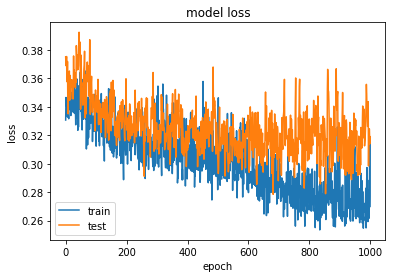

In [150]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

1886/1886 [==============================] - 0s 18us/step

('f1_score ', 0.3425925925925926)
confusion_matrix 
[[1707  132]
 [  10   37]]


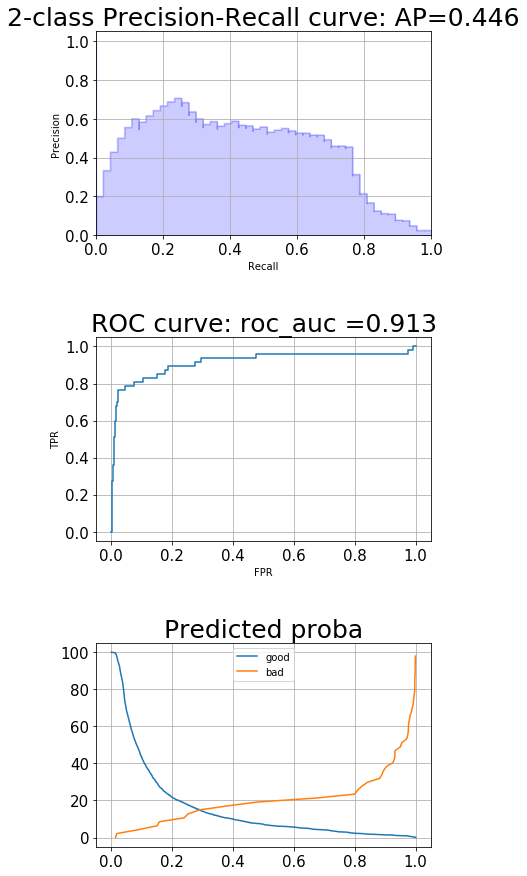

In [151]:
y_pred = net.predict(X_test, verbose=1)
print ('')
perfomance(y_test, y_pred)

## Classic methods

In [152]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

Isolation Forest
('recall_score ', 0.9787234042553191)
('precision_score ', 0.4423076923076923)
('f1_score ', 0.6092715231788078)
confusion_matrix 
[[1781   58]
 [   1   46]]


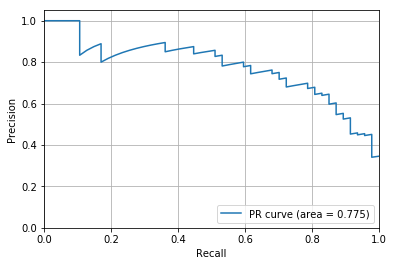

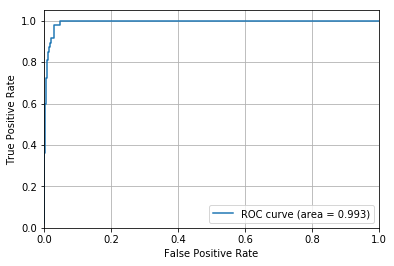

One-Class SVM
('recall_score ', 0.9148936170212766)
('precision_score ', 0.4056603773584906)
('f1_score ', 0.5620915032679739)
confusion_matrix 
[[1776   63]
 [   4   43]]


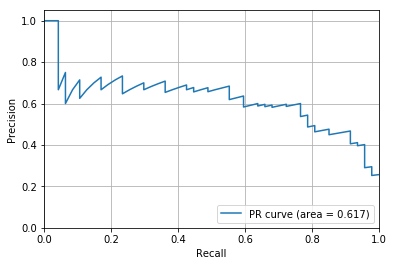

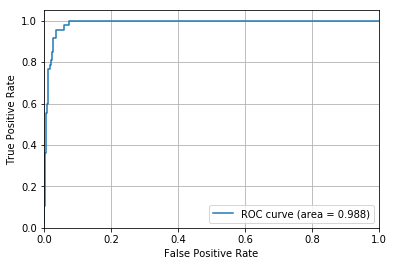

In [153]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


classifiers_classic = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)}


for i, (clf_name, clf) in enumerate(classifiers_classic.items()):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        


        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)

        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        

